## Full-optimizado + restriccion optimizada


In [7]:
import pandas as pd
import numpy as np
import ta
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass
import optuna
from sklearn.model_selection import TimeSeriesSplit

# import emyrical ← No funciona en Python 3.13 :(

In [8]:
# 1. CONFIG INICIAL
sns.set_theme(style="whitegrid")

@dataclass
class Operation:
    """Clase para almacenar la información de una operación de trading."""
    open_time: pd.Timestamp
    open_price: float
    n_shares: int
    type: str
    stop_loss: float
    take_profit: float
    status: str = 'OPEN'
    close_time: pd.Timestamp = None
    close_price: float = None
    pnl: float = 0.0

In [9]:
# 2. SEÑALES
def calculate_indicators(df: pd.DataFrame, params: dict) -> pd.DataFrame:
    """Calcula y añade los indicadores técnicos al DataFrame."""
    df_copy = df.copy()
    df_copy['rsi'] = ta.momentum.RSIIndicator(df_copy['Close'], window=params['rsi_window']).rsi()
    bollinger = ta.volatility.BollingerBands(df_copy['Close'], window=params['bb_window'], window_dev=2)
    df_copy['bb_high'] = bollinger.bollinger_hband()
    df_copy['bb_low'] = bollinger.bollinger_lband()
    stochastic = ta.momentum.StochasticOscillator(
        df_copy['High'], df_copy['Low'], df_copy['Close'],
        window=params['stoch_window'], smooth_window=params['stoch_smooth_k']
    )
    df_copy['stoch_k'] = stochastic.stoch()
    macd = ta.trend.MACD(
        df_copy['Close'], window_slow=params['macd_long_window'],
        window_fast=params['macd_short_window'], window_sign=params['macd_signal_window']
    )
    df_copy['macd_line'] = macd.macd()
    df_copy['macd_signal_line'] = macd.macd_signal()
    return df_copy.dropna()

def generate_signals(df: pd.DataFrame, params: dict) -> pd.DataFrame:
    """Genera señales de compra y venta basadas en el consenso de los indicadores."""
    df_copy = df.copy()
    rsi_buy = df_copy['rsi'] < params['rsi_lower']
    rsi_sell = df_copy['rsi'] > params['rsi_upper']
    bb_buy = df_copy['Close'] < df_copy['bb_low']
    bb_sell = df_copy['Close'] > df_copy['bb_high']
    stoch_buy = df_copy['stoch_k'] < params['stoch_buy_th']
    stoch_sell = df_copy['stoch_k'] > params['stoch_sell_th']
    macd_buy = df_copy['macd_line'] > df_copy['macd_signal_line']
    macd_sell = df_copy['macd_line'] < df_copy['macd_signal_line']

    df_copy['buy_signal'] = (rsi_buy.astype(int) + bb_buy.astype(int) + stoch_buy.astype(int) + macd_buy.astype(int)) >= 2
    df_copy['sell_signal'] = (rsi_sell.astype(int) + bb_sell.astype(int) + stoch_sell.astype(int) + macd_sell.astype(int)) >= 2
    return df_copy

In [10]:
# 3. BACKTESTING
def run_backtest(df: pd.DataFrame, initial_cash: float, commission: float, params: dict):
    """Ejecuta la simulación de trading. Usa la lógica de shorts del código de referencia."""
    cash = initial_cash
    n_shares = params['n_shares']
    sl_pct = params['stop_loss']
    tp_pct = params['take_profit']
    max_short_pct = params.get('max_short_pct', 1.0)

    active_positions: list[Operation] = []
    closed_trades_log: list[Operation] = []
    portfolio_history = [{'timestamp': df.index[0], 'value': initial_cash}]

    # Pre-calcular señales
    df_with_signals = generate_signals(calculate_indicators(df, params), params)

    for timestamp, row in df_with_signals.iterrows():
        current_price = row['Close']

        # Cierre de posiciones
        for position in active_positions[:]:
            if position.type == 'LONG' and (current_price >= position.take_profit or current_price <= position.stop_loss):
                cash += current_price * position.n_shares * (1 - commission)
                position.status = 'CLOSED'; closed_trades_log.append(position)
                active_positions.remove(position)
            elif position.type == 'SHORT' and (current_price <= position.take_profit or current_price >= position.stop_loss):
                pnl = (position.open_price - current_price) * position.n_shares * (1 - commission)
                initial_margin = position.open_price * position.n_shares * (1 + commission)
                cash += pnl + initial_margin
                position.status = 'CLOSED'; closed_trades_log.append(position)
                active_positions.remove(position)

        # Portafolio (basado en cash + valor de longs)
        long_value = sum(p.n_shares * current_price for p in active_positions if p.type == 'LONG')
        current_equity = cash + long_value
        if current_equity <= 0:
            portfolio_history.append({'timestamp': timestamp, 'value': current_equity})
            continue

        # Apertura de posiciones
        if n_shares > 0:
            cost_of_long = current_price * n_shares * (1 + commission)
            if row['buy_signal'] and cash >= cost_of_long:
                cash -= cost_of_long
                active_positions.append(Operation(
                    open_time=timestamp, open_price=current_price, n_shares=n_shares, type='LONG',
                    stop_loss=current_price * (1 - sl_pct), take_profit=current_price * (1 + tp_pct)
                ))
            elif row['sell_signal']:
                n_longs = sum(1 for p in active_positions if p.type == 'LONG')
                n_shorts = sum(1 for p in active_positions if p.type == 'SHORT')
                position_margin = current_price * n_shares * (1 + commission)
                if (n_shorts + 1) / (n_longs + n_shorts + 1) <= max_short_pct and cash >= position_margin:
                    cash -= position_margin
                    active_positions.append(Operation(
                        open_time=timestamp, open_price=current_price, n_shares=n_shares, type='SHORT',
                        stop_loss=current_price * (1 + sl_pct), take_profit=current_price * (1 - tp_pct)
                    ))

        # Valor del portafolio para el histórico
        final_long_value = sum(p.n_shares * current_price for p in active_positions if p.type == 'LONG')
        portfolio_value = cash + final_long_value
        portfolio_history.append({'timestamp': timestamp, 'value': portfolio_value})

    # Cerrar posiciones al final
    last_price = df['Close'].iloc[-1]
    for pos in active_positions[:]: # Cerrar todas las posiciones abiertas
        if pos.type == 'LONG': cash += last_price * pos.n_shares * (1 - commission)
        elif pos.type == 'SHORT':
            pnl = (pos.open_price - last_price) * pos.n_shares * (1 - commission)
            initial_margin = pos.open_price * pos.n_shares * (1 + commission)
            cash += pnl + initial_margin

    if portfolio_history: portfolio_history[-1]['value'] = cash

    portfolio_df = pd.DataFrame(portfolio_history).set_index('timestamp')['value']
    return cash, portfolio_df, closed_trades_log, active_positions

In [11]:
# 4. MÉTRICAS, GRÁFICAS Y OPTIMIZACIÓN
def calculate_performance_metrics(portfolio_values: pd.Series, trades_log: list, time_frame_minutes: int) -> dict:
    """Calcula el set completo de métricas de desempeño."""
    if portfolio_values.empty or len(trades_log) == 0:
        return {'Calmar Ratio': 0.0, 'Sharpe Ratio': 0.0, 'Sortino Ratio': 0.0, 'Max Drawdown': 0.0, 'Win Rate': 0.0, 'Total Trades': 0, 'Annualized Return': 0.0}

    returns = portfolio_values.pct_change().dropna()
    if returns.empty:
        return {'Calmar Ratio': 0.0, 'Sharpe Ratio': 0.0, 'Sortino Ratio': 0.0, 'Max Drawdown': 0.0, 'Win Rate': 0.0, 'Total Trades': len(trades_log), 'Annualized Return': 0.0}

    bars_per_year = (24 * 60 / time_frame_minutes) * 365
    annualized_return = returns.mean() * bars_per_year
    annualized_std_dev = returns.std() * np.sqrt(bars_per_year)
    sharpe_ratio = annualized_return / annualized_std_dev if annualized_std_dev != 0 else 0.0
    downside_returns = returns[returns < 0]
    annualized_downside_risk = (downside_returns.std() if not downside_returns.empty else 0) * np.sqrt(bars_per_year)
    sortino_ratio = annualized_return / annualized_downside_risk if annualized_downside_risk != 0 else 0.0
    cumulative_max = portfolio_values.cummax()
    drawdown = (cumulative_max - portfolio_values) / cumulative_max
    max_drawdown = drawdown.max()
    calmar_ratio = annualized_return / max_drawdown if max_drawdown > 0 else 0.0
    win_rate = sum(1 for trade in trades_log if trade.pnl > 0) / len(trades_log) if trades_log else 0.0

    metrics = {'Annualized Return': annualized_return, 'Calmar Ratio': calmar_ratio, 'Sharpe Ratio': sharpe_ratio, 'Sortino Ratio': sortino_ratio, 'Max Drawdown': max_drawdown, 'Win Rate': win_rate, 'Total Trades': len(trades_log)}
    return {key: round(value, 4) for key, value in metrics.items()}

def calculate_calmar_for_optimization(portfolio_values: pd.Series) -> float:
    """Versión ligera que solo calcula el Calmar Ratio para Optuna."""
    if portfolio_values.empty or portfolio_values.nunique() < 2: return -1.0
    returns = portfolio_values.pct_change().dropna()
    if returns.empty: return -1.0

    annualized_return = returns.mean() * (24 * 365)
    cumulative_max = portfolio_values.cummax()
    drawdown = (cumulative_max - portfolio_values) / cumulative_max
    max_drawdown = drawdown.max()
    return annualized_return / max_drawdown if max_drawdown > 0 else -1.0

def backtest_for_walkforward(data, params):
    """Función wrapper para el backtest dentro de walk_forward."""
    _, portfolio_df, trades_log, _ = run_backtest(data, 1_000_000, 0.00125, params)
    if len(trades_log) < 10: return -1.0 # Penalizar si hay muy pocas operaciones
    return calculate_calmar_for_optimization(portfolio_df)

def walk_forward(data, trial, n_splits=5):
    """Ejecuta la optimización usando validación cruzada de series de tiempo."""
    tscv = TimeSeriesSplit(n_splits=n_splits)
    results = []
    params = get_params_from_trial(trial)
    for _, test_index in tscv.split(data):
        validation_set = data.iloc[test_index]
        result = backtest_for_walkforward(validation_set, params)
        results.append(result)
    return np.mean(results)

def get_params_from_trial(trial):
    """Centraliza la definición de parámetros para Optuna."""
    return {
        'rsi_window': trial.suggest_int('rsi_window', 5, 50),
        'rsi_lower': trial.suggest_int('rsi_lower', 5, 35),
        'rsi_upper': trial.suggest_int('rsi_upper', 65, 95),
        'bb_window': trial.suggest_int('bb_window', 10, 50),
        'stoch_window': trial.suggest_int('stoch_window', 10, 50),
        'stoch_smooth_k': trial.suggest_int('stoch_smooth_k', 3, 10),
        'stoch_buy_th': trial.suggest_int('stoch_buy_th', 10, 30),
        'stoch_sell_th': trial.suggest_int('stoch_sell_th', 70, 90),
        'macd_short_window': trial.suggest_int('macd_short_window', 5, 50),
        'macd_long_window': trial.suggest_int('macd_long_window', 100, 300),
        'macd_signal_window': trial.suggest_int('macd_signal_window', 5, 50),
        'stop_loss': trial.suggest_float('stop_loss', 0.01, 0.15),
        'take_profit': trial.suggest_float('take_profit', 0.01, 0.15),
        'n_shares': trial.suggest_int('n_shares', 1, 10),
        'max_short_pct': trial.suggest_float('max_short_pct', 0.1, 0.5)
    }

def plot_split_performance(test_portfolio, validation_portfolio):
    """Grafica el rendimiento en los periodos de Test y Validation."""
    plt.figure(figsize=(15, 7))
    test_portfolio.plot(label='Test', color='orange')
    validation_portfolio.plot(label='Validation', color='green')
    plt.title('Rendimiento del Portafolio (Test + Validation)'); plt.xlabel('Fecha')
    plt.ylabel('Valor del Portafolio (USD)'); plt.legend(); plt.show()

def plot_vs_buy_and_hold(strategy_portfolio, price_data, initial_cash):
    """Grafica la estrategia vs. Comprar y Mantener solo en el periodo de la data proveída."""
    buy_and_hold_shares = initial_cash / price_data.iloc[0]
    buy_and_hold_portfolio = buy_and_hold_shares * price_data

    plt.figure(figsize=(15, 7))
    strategy_portfolio.plot(label='Estrategia Optimizada', color='blue')
    buy_and_hold_portfolio.plot(label='Comprar y Mantener (Buy and Hold)', color='gray', linestyle='--')
    plt.title('Estrategia Optimizada vs. Comprar y Mantener (Test + Validation)')
    plt.xlabel('Fecha'); plt.ylabel('Valor del Portafolio (USD)'); plt.legend(); plt.show()

In [12]:
# --- 5. FUNCIÓN PRINCIPAL ---
def main():
    DATA_FILE = 'Binance_BTCUSDT_1h.csv'
    INITIAL_CASH = 1_000_000; COMMISSION = 0.00125; TIME_FRAME_MINUTES = 60

    try: data = pd.read_csv(DATA_FILE, skiprows=1)
    except FileNotFoundError: print(f"Error: No se encontró '{DATA_FILE}'."); return
    data['Date'] = pd.to_datetime(data['Date'], format='mixed'); data = data.set_index('Date').sort_index()

    train_size = int(len(data) * 0.6); test_size = int(len(data) * 0.2)
    train_df, test_df, validation_df = data.iloc[:train_size], data.iloc[train_size:train_size + test_size], data.iloc[train_size + test_size:]

    print(f"Datos cargados: {len(data)} velas."); print("\nIniciando optimización walk-forward...")
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: walk_forward(train_df, trial, n_splits=5), n_trials=100, show_progress_bar=True)

    print(f"\nOptimización completada. Mejor Calmar Ratio promedio: {study.best_value:.4f}")
    best_params = study.best_params; print(f"Mejores parámetros: {best_params}")

    print("\nEjecutando backtest final...")
    # Ejecución en Test
    cash_after_test, test_portfolio, test_log, _ = run_backtest(test_df, INITIAL_CASH, COMMISSION, best_params)
    # Ejecución en Validation
    final_cash, validation_portfolio, validation_log, open_positions = run_backtest(validation_df, cash_after_test, COMMISSION, best_params)

    # Combinar resultados para el reporte y gráficas finales
    full_test_validation_portfolio = pd.concat([test_portfolio, validation_portfolio])
    full_test_validation_log = test_log + validation_log

    # --- Reporte de Métricas Final ---
    final_metrics = calculate_performance_metrics(full_test_validation_portfolio, full_test_validation_log, TIME_FRAME_MINUTES)
    print("\n--- Métricas de Desempeño Finales (Test + Validation) ---")
    final_value = full_test_validation_portfolio.iloc[-1]
    print(f"- Valor Inicial del Periodo: ${INITIAL_CASH:,.2f} USD")
    print(f"- Valor Final del Portafolio:   ${final_value:,.2f} USD")
    open_longs = sum(1 for p in open_positions if p.type == 'LONG'); open_shorts = sum(1 for p in open_positions if p.type == 'SHORT')
    print(f"- Posiciones Abiertas (Long):   {open_longs}")
    print(f"- Posiciones Abiertas (Short):  {open_shorts}")
    print("-" * 50)
    for key, value in final_metrics.items(): print(f"- {key}: {value}")

    # --- Gráficas Finales ---
    print("\nGenerando gráficas de rendimiento...")
    # Gráfica de Train
    _, train_portfolio, _, _ = run_backtest(train_df, INITIAL_CASH, COMMISSION, best_params)
    plt.figure(figsize=(15, 7)); train_portfolio.plot(title='Rendimiento en Entrenamiento'); plt.show()
    # Gráfica de Test + Validation
    plot_split_performance(test_portfolio, validation_portfolio)
    # Gráfica vs. Buy & Hold (solo en periodo Test + Validation)
    full_test_validation_prices = pd.concat([test_df['Close'], validation_df['Close']])
    plot_vs_buy_and_hold(full_test_validation_portfolio, full_test_validation_prices, INITIAL_CASH)

[I 2025-10-03 12:27:53,318] A new study created in memory with name: no-name-621e3891-5296-4c4b-8282-69af822617af


Datos cargados: 70827 velas.

Iniciando optimización walk-forward...


Best trial: 0. Best value: 0.226136:   1%|          | 1/100 [00:01<03:05,  1.87s/it]

[I 2025-10-03 12:27:55,192] Trial 0 finished with value: 0.22613630999459033 and parameters: {'rsi_window': 22, 'rsi_lower': 15, 'rsi_upper': 65, 'bb_window': 14, 'stoch_window': 48, 'stoch_smooth_k': 4, 'stoch_buy_th': 23, 'stoch_sell_th': 82, 'macd_short_window': 7, 'macd_long_window': 104, 'macd_signal_window': 32, 'stop_loss': 0.041634445074188835, 'take_profit': 0.04908769831499224, 'n_shares': 8, 'max_short_pct': 0.2549816114422392}. Best is trial 0 with value: 0.22613630999459033.


Best trial: 1. Best value: 0.413693:   2%|▏         | 2/100 [00:03<03:01,  1.85s/it]

[I 2025-10-03 12:27:57,024] Trial 1 finished with value: 0.41369319390075765 and parameters: {'rsi_window': 29, 'rsi_lower': 10, 'rsi_upper': 93, 'bb_window': 42, 'stoch_window': 48, 'stoch_smooth_k': 7, 'stoch_buy_th': 25, 'stoch_sell_th': 75, 'macd_short_window': 39, 'macd_long_window': 108, 'macd_signal_window': 27, 'stop_loss': 0.08237723045730275, 'take_profit': 0.08156209508620803, 'n_shares': 4, 'max_short_pct': 0.22106317170939374}. Best is trial 1 with value: 0.41369319390075765.


Best trial: 2. Best value: 1.87003:   3%|▎         | 3/100 [00:05<02:55,  1.81s/it] 

[I 2025-10-03 12:27:58,788] Trial 2 finished with value: 1.8700317020751338 and parameters: {'rsi_window': 48, 'rsi_lower': 18, 'rsi_upper': 72, 'bb_window': 23, 'stoch_window': 33, 'stoch_smooth_k': 7, 'stoch_buy_th': 25, 'stoch_sell_th': 81, 'macd_short_window': 33, 'macd_long_window': 229, 'macd_signal_window': 44, 'stop_loss': 0.11641647629348932, 'take_profit': 0.09019469726118534, 'n_shares': 7, 'max_short_pct': 0.4948048848356309}. Best is trial 2 with value: 1.8700317020751338.


Best trial: 2. Best value: 1.87003:   4%|▍         | 4/100 [00:07<02:51,  1.79s/it]

[I 2025-10-03 12:28:00,545] Trial 3 finished with value: 0.1799606637858354 and parameters: {'rsi_window': 45, 'rsi_lower': 15, 'rsi_upper': 89, 'bb_window': 43, 'stoch_window': 25, 'stoch_smooth_k': 6, 'stoch_buy_th': 22, 'stoch_sell_th': 77, 'macd_short_window': 41, 'macd_long_window': 220, 'macd_signal_window': 6, 'stop_loss': 0.14319401191916822, 'take_profit': 0.013436976570122465, 'n_shares': 1, 'max_short_pct': 0.37645150115789316}. Best is trial 2 with value: 1.8700317020751338.


Best trial: 4. Best value: 2.68951:   5%|▌         | 5/100 [00:08<02:47,  1.77s/it]

[I 2025-10-03 12:28:02,270] Trial 4 finished with value: 2.6895130844249424 and parameters: {'rsi_window': 33, 'rsi_lower': 8, 'rsi_upper': 70, 'bb_window': 20, 'stoch_window': 23, 'stoch_smooth_k': 6, 'stoch_buy_th': 17, 'stoch_sell_th': 78, 'macd_short_window': 13, 'macd_long_window': 115, 'macd_signal_window': 40, 'stop_loss': 0.02592689622283599, 'take_profit': 0.036163885957598146, 'n_shares': 4, 'max_short_pct': 0.41513396248547807}. Best is trial 4 with value: 2.6895130844249424.


Best trial: 4. Best value: 2.68951:   6%|▌         | 6/100 [00:11<03:16,  2.09s/it]

[I 2025-10-03 12:28:04,980] Trial 5 finished with value: 0.30555953322279195 and parameters: {'rsi_window': 13, 'rsi_lower': 15, 'rsi_upper': 72, 'bb_window': 50, 'stoch_window': 21, 'stoch_smooth_k': 9, 'stoch_buy_th': 11, 'stoch_sell_th': 87, 'macd_short_window': 21, 'macd_long_window': 225, 'macd_signal_window': 37, 'stop_loss': 0.03693464464980934, 'take_profit': 0.1153398024755542, 'n_shares': 9, 'max_short_pct': 0.2225711560393775}. Best is trial 4 with value: 2.6895130844249424.


Best trial: 4. Best value: 2.68951:   7%|▋         | 7/100 [00:13<03:06,  2.00s/it]

[I 2025-10-03 12:28:06,805] Trial 6 finished with value: 0.3760277629295662 and parameters: {'rsi_window': 47, 'rsi_lower': 5, 'rsi_upper': 87, 'bb_window': 37, 'stoch_window': 40, 'stoch_smooth_k': 8, 'stoch_buy_th': 12, 'stoch_sell_th': 81, 'macd_short_window': 21, 'macd_long_window': 209, 'macd_signal_window': 12, 'stop_loss': 0.12587572702172076, 'take_profit': 0.03880900308173938, 'n_shares': 10, 'max_short_pct': 0.31609626034227856}. Best is trial 4 with value: 2.6895130844249424.


Best trial: 4. Best value: 2.68951:   8%|▊         | 8/100 [00:15<03:16,  2.13s/it]

[I 2025-10-03 12:28:09,220] Trial 7 finished with value: 1.8004750141939951 and parameters: {'rsi_window': 41, 'rsi_lower': 28, 'rsi_upper': 90, 'bb_window': 47, 'stoch_window': 11, 'stoch_smooth_k': 6, 'stoch_buy_th': 19, 'stoch_sell_th': 90, 'macd_short_window': 40, 'macd_long_window': 294, 'macd_signal_window': 48, 'stop_loss': 0.12456654941617153, 'take_profit': 0.08174772031942974, 'n_shares': 6, 'max_short_pct': 0.4505946569831174}. Best is trial 4 with value: 2.6895130844249424.


Best trial: 4. Best value: 2.68951:   9%|▉         | 9/100 [00:18<03:26,  2.27s/it]

[I 2025-10-03 12:28:11,802] Trial 8 finished with value: 1.4197971388725914 and parameters: {'rsi_window': 45, 'rsi_lower': 33, 'rsi_upper': 95, 'bb_window': 18, 'stoch_window': 39, 'stoch_smooth_k': 8, 'stoch_buy_th': 28, 'stoch_sell_th': 70, 'macd_short_window': 37, 'macd_long_window': 272, 'macd_signal_window': 30, 'stop_loss': 0.01365912960720314, 'take_profit': 0.14802655237958898, 'n_shares': 2, 'max_short_pct': 0.4189897544910621}. Best is trial 4 with value: 2.6895130844249424.


Best trial: 4. Best value: 2.68951:  10%|█         | 10/100 [00:20<03:27,  2.30s/it]

[I 2025-10-03 12:28:14,178] Trial 9 finished with value: 1.3673743887459644 and parameters: {'rsi_window': 40, 'rsi_lower': 33, 'rsi_upper': 66, 'bb_window': 25, 'stoch_window': 36, 'stoch_smooth_k': 4, 'stoch_buy_th': 27, 'stoch_sell_th': 72, 'macd_short_window': 6, 'macd_long_window': 236, 'macd_signal_window': 14, 'stop_loss': 0.1379008670703211, 'take_profit': 0.12320948442725548, 'n_shares': 6, 'max_short_pct': 0.3407898649810189}. Best is trial 4 with value: 2.6895130844249424.


Best trial: 4. Best value: 2.68951:  11%|█         | 11/100 [00:22<03:16,  2.21s/it]

[I 2025-10-03 12:28:16,165] Trial 10 finished with value: -0.19595006138837745 and parameters: {'rsi_window': 32, 'rsi_lower': 25, 'rsi_upper': 79, 'bb_window': 10, 'stoch_window': 16, 'stoch_smooth_k': 3, 'stoch_buy_th': 17, 'stoch_sell_th': 77, 'macd_short_window': 16, 'macd_long_window': 151, 'macd_signal_window': 22, 'stop_loss': 0.07580288978246706, 'take_profit': 0.045272828502939844, 'n_shares': 4, 'max_short_pct': 0.11137524702851581}. Best is trial 4 with value: 2.6895130844249424.


Best trial: 4. Best value: 2.68951:  12%|█▏        | 12/100 [00:24<03:06,  2.12s/it]

[I 2025-10-03 12:28:18,094] Trial 11 finished with value: 1.4171967361026216 and parameters: {'rsi_window': 36, 'rsi_lower': 5, 'rsi_upper': 74, 'bb_window': 27, 'stoch_window': 30, 'stoch_smooth_k': 10, 'stoch_buy_th': 15, 'stoch_sell_th': 84, 'macd_short_window': 29, 'macd_long_window': 171, 'macd_signal_window': 46, 'stop_loss': 0.09642652126176968, 'take_profit': 0.10366584160114266, 'n_shares': 7, 'max_short_pct': 0.497991182706539}. Best is trial 4 with value: 2.6895130844249424.


Best trial: 4. Best value: 2.68951:  13%|█▎        | 13/100 [00:26<03:03,  2.10s/it]

[I 2025-10-03 12:28:20,156] Trial 12 finished with value: 2.6117837257539125 and parameters: {'rsi_window': 22, 'rsi_lower': 21, 'rsi_upper': 72, 'bb_window': 21, 'stoch_window': 32, 'stoch_smooth_k': 5, 'stoch_buy_th': 30, 'stoch_sell_th': 79, 'macd_short_window': 48, 'macd_long_window': 169, 'macd_signal_window': 41, 'stop_loss': 0.10526558884016278, 'take_profit': 0.06396180838206675, 'n_shares': 4, 'max_short_pct': 0.4951030160541427}. Best is trial 4 with value: 2.6895130844249424.


Best trial: 4. Best value: 2.68951:  14%|█▍        | 14/100 [00:28<02:54,  2.03s/it]

[I 2025-10-03 12:28:22,025] Trial 13 finished with value: 2.1928121273806727 and parameters: {'rsi_window': 21, 'rsi_lower': 23, 'rsi_upper': 78, 'bb_window': 31, 'stoch_window': 26, 'stoch_smooth_k': 5, 'stoch_buy_th': 30, 'stoch_sell_th': 77, 'macd_short_window': 47, 'macd_long_window': 150, 'macd_signal_window': 38, 'stop_loss': 0.061062703046398124, 'take_profit': 0.058453069590446174, 'n_shares': 4, 'max_short_pct': 0.3993892875517616}. Best is trial 4 with value: 2.6895130844249424.


Best trial: 14. Best value: 4.04456:  15%|█▌        | 15/100 [00:30<02:48,  1.98s/it]

[I 2025-10-03 12:28:23,873] Trial 14 finished with value: 4.044561366560396 and parameters: {'rsi_window': 9, 'rsi_lower': 20, 'rsi_upper': 68, 'bb_window': 18, 'stoch_window': 18, 'stoch_smooth_k': 5, 'stoch_buy_th': 15, 'stoch_sell_th': 74, 'macd_short_window': 48, 'macd_long_window': 170, 'macd_signal_window': 40, 'stop_loss': 0.09578772135812046, 'take_profit': 0.01708353911160998, 'n_shares': 3, 'max_short_pct': 0.45087328584820585}. Best is trial 14 with value: 4.044561366560396.


Best trial: 14. Best value: 4.04456:  16%|█▌        | 16/100 [00:32<02:40,  1.92s/it]

[I 2025-10-03 12:28:25,645] Trial 15 finished with value: 0.009169097508978753 and parameters: {'rsi_window': 7, 'rsi_lower': 10, 'rsi_upper': 67, 'bb_window': 16, 'stoch_window': 17, 'stoch_smooth_k': 5, 'stoch_buy_th': 14, 'stoch_sell_th': 73, 'macd_short_window': 15, 'macd_long_window': 129, 'macd_signal_window': 50, 'stop_loss': 0.014346903062677451, 'take_profit': 0.0122888696326943, 'n_shares': 2, 'max_short_pct': 0.4323879106772306}. Best is trial 14 with value: 4.044561366560396.


Best trial: 14. Best value: 4.04456:  17%|█▋        | 17/100 [00:34<02:42,  1.96s/it]

[I 2025-10-03 12:28:27,716] Trial 16 finished with value: 3.01865339387084 and parameters: {'rsi_window': 14, 'rsi_lower': 9, 'rsi_upper': 69, 'bb_window': 32, 'stoch_window': 11, 'stoch_smooth_k': 3, 'stoch_buy_th': 18, 'stoch_sell_th': 74, 'macd_short_window': 24, 'macd_long_window': 181, 'macd_signal_window': 36, 'stop_loss': 0.05535115525216125, 'take_profit': 0.030661252726588074, 'n_shares': 3, 'max_short_pct': 0.3612606699453822}. Best is trial 14 with value: 4.044561366560396.


Best trial: 14. Best value: 4.04456:  18%|█▊        | 18/100 [00:36<02:46,  2.03s/it]

[I 2025-10-03 12:28:29,915] Trial 17 finished with value: 2.172456030108747 and parameters: {'rsi_window': 8, 'rsi_lower': 28, 'rsi_upper': 84, 'bb_window': 34, 'stoch_window': 11, 'stoch_smooth_k': 3, 'stoch_buy_th': 20, 'stoch_sell_th': 74, 'macd_short_window': 25, 'macd_long_window': 183, 'macd_signal_window': 34, 'stop_loss': 0.06190221550077638, 'take_profit': 0.02603518073985961, 'n_shares': 2, 'max_short_pct': 0.3584736393601185}. Best is trial 14 with value: 4.044561366560396.


Best trial: 14. Best value: 4.04456:  19%|█▉        | 19/100 [00:38<02:37,  1.95s/it]

[I 2025-10-03 12:28:31,666] Trial 18 finished with value: 1.0685722684800634 and parameters: {'rsi_window': 14, 'rsi_lower': 19, 'rsi_upper': 77, 'bb_window': 29, 'stoch_window': 16, 'stoch_smooth_k': 4, 'stoch_buy_th': 14, 'stoch_sell_th': 70, 'macd_short_window': 30, 'macd_long_window': 191, 'macd_signal_window': 25, 'stop_loss': 0.05660426190200207, 'take_profit': 0.025804067491250825, 'n_shares': 3, 'max_short_pct': 0.2837594437218782}. Best is trial 14 with value: 4.044561366560396.


Best trial: 14. Best value: 4.04456:  20%|██        | 20/100 [00:40<02:32,  1.90s/it]

[I 2025-10-03 12:28:33,461] Trial 19 finished with value: -0.18302290987319658 and parameters: {'rsi_window': 15, 'rsi_lower': 12, 'rsi_upper': 82, 'bb_window': 36, 'stoch_window': 10, 'stoch_smooth_k': 3, 'stoch_buy_th': 10, 'stoch_sell_th': 72, 'macd_short_window': 23, 'macd_long_window': 258, 'macd_signal_window': 20, 'stop_loss': 0.08691138637911491, 'take_profit': 0.05782313074291548, 'n_shares': 1, 'max_short_pct': 0.15501062984591327}. Best is trial 14 with value: 4.044561366560396.


Best trial: 14. Best value: 4.04456:  21%|██        | 21/100 [00:41<02:27,  1.87s/it]

[I 2025-10-03 12:28:35,239] Trial 20 finished with value: 1.7786451390188467 and parameters: {'rsi_window': 10, 'rsi_lower': 29, 'rsi_upper': 69, 'bb_window': 11, 'stoch_window': 20, 'stoch_smooth_k': 4, 'stoch_buy_th': 18, 'stoch_sell_th': 75, 'macd_short_window': 34, 'macd_long_window': 143, 'macd_signal_window': 35, 'stop_loss': 0.07348143177895708, 'take_profit': 0.025598090982761876, 'n_shares': 5, 'max_short_pct': 0.3127160315783064}. Best is trial 14 with value: 4.044561366560396.


Best trial: 14. Best value: 4.04456:  22%|██▏       | 22/100 [00:43<02:26,  1.88s/it]

[I 2025-10-03 12:28:37,138] Trial 21 finished with value: 3.3435404385567864 and parameters: {'rsi_window': 5, 'rsi_lower': 8, 'rsi_upper': 69, 'bb_window': 20, 'stoch_window': 23, 'stoch_smooth_k': 6, 'stoch_buy_th': 16, 'stoch_sell_th': 79, 'macd_short_window': 12, 'macd_long_window': 171, 'macd_signal_window': 41, 'stop_loss': 0.035548457627330554, 'take_profit': 0.03899902420624294, 'n_shares': 3, 'max_short_pct': 0.43863153675777633}. Best is trial 14 with value: 4.044561366560396.


Best trial: 14. Best value: 4.04456:  23%|██▎       | 23/100 [00:45<02:27,  1.92s/it]

[I 2025-10-03 12:28:39,148] Trial 22 finished with value: 1.1470552420556903 and parameters: {'rsi_window': 5, 'rsi_lower': 7, 'rsi_upper': 76, 'bb_window': 32, 'stoch_window': 16, 'stoch_smooth_k': 5, 'stoch_buy_th': 16, 'stoch_sell_th': 84, 'macd_short_window': 10, 'macd_long_window': 171, 'macd_signal_window': 43, 'stop_loss': 0.04744928265455541, 'take_profit': 0.011259769435326982, 'n_shares': 3, 'max_short_pct': 0.45403532880519015}. Best is trial 14 with value: 4.044561366560396.


Best trial: 14. Best value: 4.04456:  24%|██▍       | 24/100 [00:47<02:27,  1.94s/it]

[I 2025-10-03 12:28:41,138] Trial 23 finished with value: 2.1087495817223143 and parameters: {'rsi_window': 19, 'rsi_lower': 12, 'rsi_upper': 68, 'bb_window': 24, 'stoch_window': 13, 'stoch_smooth_k': 7, 'stoch_buy_th': 12, 'stoch_sell_th': 75, 'macd_short_window': 18, 'macd_long_window': 200, 'macd_signal_window': 30, 'stop_loss': 0.03333015792055978, 'take_profit': 0.030358705558105797, 'n_shares': 3, 'max_short_pct': 0.3834834399968032}. Best is trial 14 with value: 4.044561366560396.


Best trial: 14. Best value: 4.04456:  25%|██▌       | 25/100 [00:49<02:23,  1.92s/it]

[I 2025-10-03 12:28:43,009] Trial 24 finished with value: 3.8547806676809544 and parameters: {'rsi_window': 10, 'rsi_lower': 17, 'rsi_upper': 74, 'bb_window': 15, 'stoch_window': 27, 'stoch_smooth_k': 6, 'stoch_buy_th': 19, 'stoch_sell_th': 79, 'macd_short_window': 45, 'macd_long_window': 182, 'macd_signal_window': 39, 'stop_loss': 0.04968295494670042, 'take_profit': 0.06642840891352753, 'n_shares': 5, 'max_short_pct': 0.4638521240671534}. Best is trial 14 with value: 4.044561366560396.


Best trial: 14. Best value: 4.04456:  26%|██▌       | 26/100 [00:51<02:19,  1.89s/it]

[I 2025-10-03 12:28:44,819] Trial 25 finished with value: 2.8439263257614074 and parameters: {'rsi_window': 11, 'rsi_lower': 18, 'rsi_upper': 75, 'bb_window': 14, 'stoch_window': 29, 'stoch_smooth_k': 6, 'stoch_buy_th': 21, 'stoch_sell_th': 84, 'macd_short_window': 44, 'macd_long_window': 159, 'macd_signal_window': 45, 'stop_loss': 0.025584451720220745, 'take_profit': 0.0693293112083008, 'n_shares': 5, 'max_short_pct': 0.46115317794691013}. Best is trial 14 with value: 4.044561366560396.


Best trial: 14. Best value: 4.04456:  27%|██▋       | 27/100 [00:53<02:15,  1.86s/it]

[I 2025-10-03 12:28:46,621] Trial 26 finished with value: 2.4421913033803704 and parameters: {'rsi_window': 18, 'rsi_lower': 22, 'rsi_upper': 73, 'bb_window': 18, 'stoch_window': 26, 'stoch_smooth_k': 8, 'stoch_buy_th': 14, 'stoch_sell_th': 79, 'macd_short_window': 50, 'macd_long_window': 125, 'macd_signal_window': 40, 'stop_loss': 0.09399466404566759, 'take_profit': 0.04855818644395371, 'n_shares': 5, 'max_short_pct': 0.4568165078136435}. Best is trial 14 with value: 4.044561366560396.


Best trial: 14. Best value: 4.04456:  28%|██▊       | 28/100 [00:55<02:16,  1.89s/it]

[I 2025-10-03 12:28:48,577] Trial 27 finished with value: 3.304299229247566 and parameters: {'rsi_window': 5, 'rsi_lower': 25, 'rsi_upper': 70, 'bb_window': 13, 'stoch_window': 20, 'stoch_smooth_k': 5, 'stoch_buy_th': 20, 'stoch_sell_th': 82, 'macd_short_window': 45, 'macd_long_window': 204, 'macd_signal_window': 49, 'stop_loss': 0.07060106739233935, 'take_profit': 0.06969338230061933, 'n_shares': 2, 'max_short_pct': 0.47370781014829805}. Best is trial 14 with value: 4.044561366560396.


Best trial: 14. Best value: 4.04456:  29%|██▉       | 29/100 [00:57<02:13,  1.88s/it]

[I 2025-10-03 12:28:50,447] Trial 28 finished with value: 2.7114627594217646 and parameters: {'rsi_window': 10, 'rsi_lower': 13, 'rsi_upper': 81, 'bb_window': 17, 'stoch_window': 23, 'stoch_smooth_k': 7, 'stoch_buy_th': 15, 'stoch_sell_th': 86, 'macd_short_window': 43, 'macd_long_window': 141, 'macd_signal_window': 42, 'stop_loss': 0.04720780253353179, 'take_profit': 0.09416521213347594, 'n_shares': 6, 'max_short_pct': 0.4165030407450221}. Best is trial 14 with value: 4.044561366560396.


Best trial: 14. Best value: 4.04456:  30%|███       | 30/100 [00:58<02:10,  1.86s/it]

[I 2025-10-03 12:28:52,261] Trial 29 finished with value: 2.0056265226866534 and parameters: {'rsi_window': 18, 'rsi_lower': 16, 'rsi_upper': 65, 'bb_window': 14, 'stoch_window': 28, 'stoch_smooth_k': 6, 'stoch_buy_th': 23, 'stoch_sell_th': 80, 'macd_short_window': 9, 'macd_long_window': 187, 'macd_signal_window': 32, 'stop_loss': 0.1085158272495015, 'take_profit': 0.0528715641779564, 'n_shares': 7, 'max_short_pct': 0.43877160735383447}. Best is trial 14 with value: 4.044561366560396.


Best trial: 14. Best value: 4.04456:  31%|███       | 31/100 [01:00<02:07,  1.85s/it]

[I 2025-10-03 12:28:54,097] Trial 30 finished with value: 1.687930225460684 and parameters: {'rsi_window': 26, 'rsi_lower': 17, 'rsi_upper': 66, 'bb_window': 21, 'stoch_window': 43, 'stoch_smooth_k': 4, 'stoch_buy_th': 13, 'stoch_sell_th': 76, 'macd_short_window': 34, 'macd_long_window': 165, 'macd_signal_window': 38, 'stop_loss': 0.04109119321761079, 'take_profit': 0.04379428767387909, 'n_shares': 8, 'max_short_pct': 0.39894882392368924}. Best is trial 14 with value: 4.044561366560396.


Best trial: 14. Best value: 4.04456:  32%|███▏      | 32/100 [01:02<02:07,  1.88s/it]

[I 2025-10-03 12:28:56,029] Trial 31 finished with value: 3.3692443202781677 and parameters: {'rsi_window': 5, 'rsi_lower': 25, 'rsi_upper': 70, 'bb_window': 13, 'stoch_window': 21, 'stoch_smooth_k': 5, 'stoch_buy_th': 20, 'stoch_sell_th': 81, 'macd_short_window': 46, 'macd_long_window': 203, 'macd_signal_window': 50, 'stop_loss': 0.07100454626739511, 'take_profit': 0.06882982772562393, 'n_shares': 2, 'max_short_pct': 0.4706096670312988}. Best is trial 14 with value: 4.044561366560396.


Best trial: 14. Best value: 4.04456:  33%|███▎      | 33/100 [01:04<02:06,  1.89s/it]

[I 2025-10-03 12:28:57,955] Trial 32 finished with value: 2.0424288460854334 and parameters: {'rsi_window': 8, 'rsi_lower': 25, 'rsi_upper': 71, 'bb_window': 13, 'stoch_window': 19, 'stoch_smooth_k': 5, 'stoch_buy_th': 19, 'stoch_sell_th': 79, 'macd_short_window': 49, 'macd_long_window': 212, 'macd_signal_window': 48, 'stop_loss': 0.06760099118748007, 'take_profit': 0.07263855560768662, 'n_shares': 1, 'max_short_pct': 0.47217121687427765}. Best is trial 14 with value: 4.044561366560396.


Best trial: 14. Best value: 4.04456:  34%|███▍      | 34/100 [01:06<02:03,  1.87s/it]

[I 2025-10-03 12:28:59,784] Trial 33 finished with value: 3.9331263084783616 and parameters: {'rsi_window': 5, 'rsi_lower': 20, 'rsi_upper': 68, 'bb_window': 16, 'stoch_window': 23, 'stoch_smooth_k': 6, 'stoch_buy_th': 23, 'stoch_sell_th': 82, 'macd_short_window': 37, 'macd_long_window': 193, 'macd_signal_window': 46, 'stop_loss': 0.08283220752978643, 'take_profit': 0.019011600567480316, 'n_shares': 3, 'max_short_pct': 0.47558051548759206}. Best is trial 14 with value: 4.044561366560396.


Best trial: 14. Best value: 4.04456:  35%|███▌      | 35/100 [01:08<02:02,  1.88s/it]

[I 2025-10-03 12:29:01,673] Trial 34 finished with value: 2.2873380547021376 and parameters: {'rsi_window': 25, 'rsi_lower': 20, 'rsi_upper': 74, 'bb_window': 10, 'stoch_window': 24, 'stoch_smooth_k': 7, 'stoch_buy_th': 24, 'stoch_sell_th': 82, 'macd_short_window': 37, 'macd_long_window': 247, 'macd_signal_window': 46, 'stop_loss': 0.08332928608731428, 'take_profit': 0.07985643554756941, 'n_shares': 2, 'max_short_pct': 0.48128120065343244}. Best is trial 14 with value: 4.044561366560396.


Best trial: 14. Best value: 4.04456:  36%|███▌      | 36/100 [01:10<01:58,  1.85s/it]

[I 2025-10-03 12:29:03,473] Trial 35 finished with value: 0.5238351359262088 and parameters: {'rsi_window': 12, 'rsi_lower': 23, 'rsi_upper': 67, 'bb_window': 16, 'stoch_window': 33, 'stoch_smooth_k': 5, 'stoch_buy_th': 21, 'stoch_sell_th': 83, 'macd_short_window': 46, 'macd_long_window': 195, 'macd_signal_window': 46, 'stop_loss': 0.09058632330694902, 'take_profit': 0.020318341652856335, 'n_shares': 1, 'max_short_pct': 0.47594904146645955}. Best is trial 14 with value: 4.044561366560396.


Best trial: 14. Best value: 4.04456:  37%|███▋      | 37/100 [01:11<01:56,  1.85s/it]

[I 2025-10-03 12:29:05,310] Trial 36 finished with value: 3.3905929327978335 and parameters: {'rsi_window': 8, 'rsi_lower': 19, 'rsi_upper': 65, 'bb_window': 12, 'stoch_window': 27, 'stoch_smooth_k': 6, 'stoch_buy_th': 23, 'stoch_sell_th': 86, 'macd_short_window': 41, 'macd_long_window': 223, 'macd_signal_window': 50, 'stop_loss': 0.09985534575000835, 'take_profit': 0.017100919228998396, 'n_shares': 4, 'max_short_pct': 0.4994242005697762}. Best is trial 14 with value: 4.044561366560396.


Best trial: 14. Best value: 4.04456:  38%|███▊      | 38/100 [01:13<01:54,  1.85s/it]

[I 2025-10-03 12:29:07,178] Trial 37 finished with value: -0.12105631473784254 and parameters: {'rsi_window': 16, 'rsi_lower': 14, 'rsi_upper': 65, 'bb_window': 22, 'stoch_window': 27, 'stoch_smooth_k': 7, 'stoch_buy_th': 26, 'stoch_sell_th': 87, 'macd_short_window': 42, 'macd_long_window': 100, 'macd_signal_window': 44, 'stop_loss': 0.10330363326067564, 'take_profit': 0.017447136920641714, 'n_shares': 5, 'max_short_pct': 0.20665800902867204}. Best is trial 14 with value: 4.044561366560396.


Best trial: 14. Best value: 4.04456:  39%|███▉      | 39/100 [01:16<02:08,  2.11s/it]

[I 2025-10-03 12:29:09,864] Trial 38 finished with value: 1.026240796004874 and parameters: {'rsi_window': 9, 'rsi_lower': 19, 'rsi_upper': 68, 'bb_window': 15, 'stoch_window': 50, 'stoch_smooth_k': 6, 'stoch_buy_th': 23, 'stoch_sell_th': 90, 'macd_short_window': 38, 'macd_long_window': 218, 'macd_signal_window': 47, 'stop_loss': 0.11431401207034911, 'take_profit': 0.03589444850440346, 'n_shares': 4, 'max_short_pct': 0.26960182520196163}. Best is trial 14 with value: 4.044561366560396.


Best trial: 14. Best value: 4.04456:  40%|████      | 40/100 [01:18<02:07,  2.12s/it]

[I 2025-10-03 12:29:12,023] Trial 39 finished with value: 1.5429416398351887 and parameters: {'rsi_window': 11, 'rsi_lower': 16, 'rsi_upper': 71, 'bb_window': 19, 'stoch_window': 30, 'stoch_smooth_k': 8, 'stoch_buy_th': 25, 'stoch_sell_th': 86, 'macd_short_window': 41, 'macd_long_window': 234, 'macd_signal_window': 39, 'stop_loss': 0.08001056863974183, 'take_profit': 0.018454446465248214, 'n_shares': 4, 'max_short_pct': 0.4000597736415337}. Best is trial 14 with value: 4.044561366560396.


Best trial: 14. Best value: 4.04456:  41%|████      | 41/100 [01:20<02:00,  2.05s/it]

[I 2025-10-03 12:29:13,897] Trial 40 finished with value: 1.7620333934099464 and parameters: {'rsi_window': 8, 'rsi_lower': 18, 'rsi_upper': 65, 'bb_window': 41, 'stoch_window': 36, 'stoch_smooth_k': 6, 'stoch_buy_th': 22, 'stoch_sell_th': 89, 'macd_short_window': 39, 'macd_long_window': 224, 'macd_signal_window': 43, 'stop_loss': 0.09883484359355874, 'take_profit': 0.1386713001656537, 'n_shares': 5, 'max_short_pct': 0.49292174941189587}. Best is trial 14 with value: 4.044561366560396.


Best trial: 14. Best value: 4.04456:  42%|████▏     | 42/100 [01:22<01:56,  2.02s/it]

[I 2025-10-03 12:29:15,843] Trial 41 finished with value: 2.252624865447856 and parameters: {'rsi_window': 6, 'rsi_lower': 20, 'rsi_upper': 71, 'bb_window': 12, 'stoch_window': 22, 'stoch_smooth_k': 6, 'stoch_buy_th': 22, 'stoch_sell_th': 81, 'macd_short_window': 46, 'macd_long_window': 209, 'macd_signal_window': 49, 'stop_loss': 0.12134450343844388, 'take_profit': 0.0931311677294032, 'n_shares': 3, 'max_short_pct': 0.43289116404306976}. Best is trial 14 with value: 4.044561366560396.


Best trial: 14. Best value: 4.04456:  43%|████▎     | 43/100 [01:24<01:55,  2.03s/it]

[I 2025-10-03 12:29:17,891] Trial 42 finished with value: 2.4081297786378344 and parameters: {'rsi_window': 12, 'rsi_lower': 23, 'rsi_upper': 67, 'bb_window': 12, 'stoch_window': 18, 'stoch_smooth_k': 4, 'stoch_buy_th': 24, 'stoch_sell_th': 85, 'macd_short_window': 50, 'macd_long_window': 181, 'macd_signal_window': 50, 'stop_loss': 0.07976432159726096, 'take_profit': 0.10143159311884306, 'n_shares': 2, 'max_short_pct': 0.46152042481282635}. Best is trial 14 with value: 4.044561366560396.


Best trial: 14. Best value: 4.04456:  44%|████▍     | 44/100 [01:26<01:52,  2.00s/it]

[I 2025-10-03 12:29:19,833] Trial 43 finished with value: 2.582179211629703 and parameters: {'rsi_window': 7, 'rsi_lower': 31, 'rsi_upper': 73, 'bb_window': 16, 'stoch_window': 25, 'stoch_smooth_k': 7, 'stoch_buy_th': 21, 'stoch_sell_th': 82, 'macd_short_window': 43, 'macd_long_window': 199, 'macd_signal_window': 44, 'stop_loss': 0.08788043430769843, 'take_profit': 0.020565941504347724, 'n_shares': 4, 'max_short_pct': 0.4976129995548492}. Best is trial 14 with value: 4.044561366560396.


Best trial: 14. Best value: 4.04456:  45%|████▌     | 45/100 [01:28<01:49,  1.99s/it]

[I 2025-10-03 12:29:21,785] Trial 44 finished with value: 1.4284935892010406 and parameters: {'rsi_window': 16, 'rsi_lower': 21, 'rsi_upper': 70, 'bb_window': 26, 'stoch_window': 14, 'stoch_smooth_k': 5, 'stoch_buy_th': 19, 'stoch_sell_th': 88, 'macd_short_window': 36, 'macd_long_window': 246, 'macd_signal_window': 47, 'stop_loss': 0.1125558452441222, 'take_profit': 0.07946571751799365, 'n_shares': 3, 'max_short_pct': 0.44590566264236403}. Best is trial 14 with value: 4.044561366560396.


Best trial: 14. Best value: 4.04456:  46%|████▌     | 46/100 [01:30<01:45,  1.95s/it]

[I 2025-10-03 12:29:23,652] Trial 45 finished with value: 2.651199713518598 and parameters: {'rsi_window': 9, 'rsi_lower': 24, 'rsi_upper': 68, 'bb_window': 10, 'stoch_window': 32, 'stoch_smooth_k': 6, 'stoch_buy_th': 23, 'stoch_sell_th': 78, 'macd_short_window': 40, 'macd_long_window': 219, 'macd_signal_window': 50, 'stop_loss': 0.06597723053671149, 'take_profit': 0.12104479745379096, 'n_shares': 6, 'max_short_pct': 0.4154722630945778}. Best is trial 14 with value: 4.044561366560396.


Best trial: 14. Best value: 4.04456:  47%|████▋     | 47/100 [01:32<01:41,  1.92s/it]

[I 2025-10-03 12:29:25,497] Trial 46 finished with value: 2.591374815604225 and parameters: {'rsi_window': 30, 'rsi_lower': 27, 'rsi_upper': 66, 'bb_window': 18, 'stoch_window': 20, 'stoch_smooth_k': 5, 'stoch_buy_th': 26, 'stoch_sell_th': 83, 'macd_short_window': 31, 'macd_long_window': 179, 'macd_signal_window': 42, 'stop_loss': 0.13102451412666266, 'take_profit': 0.03404542719122136, 'n_shares': 4, 'max_short_pct': 0.48033837630623033}. Best is trial 14 with value: 4.044561366560396.


Best trial: 14. Best value: 4.04456:  48%|████▊     | 48/100 [01:33<01:38,  1.89s/it]

[I 2025-10-03 12:29:27,309] Trial 47 finished with value: 1.6811693560755778 and parameters: {'rsi_window': 13, 'rsi_lower': 16, 'rsi_upper': 73, 'bb_window': 15, 'stoch_window': 22, 'stoch_smooth_k': 4, 'stoch_buy_th': 18, 'stoch_sell_th': 80, 'macd_short_window': 48, 'macd_long_window': 293, 'macd_signal_window': 45, 'stop_loss': 0.0995316371787651, 'take_profit': 0.041839762353016854, 'n_shares': 2, 'max_short_pct': 0.4275120749320913}. Best is trial 14 with value: 4.044561366560396.


Best trial: 14. Best value: 4.04456:  49%|████▉     | 49/100 [01:35<01:34,  1.86s/it]

[I 2025-10-03 12:29:29,094] Trial 48 finished with value: 0.633891596660966 and parameters: {'rsi_window': 50, 'rsi_lower': 21, 'rsi_upper': 70, 'bb_window': 23, 'stoch_window': 25, 'stoch_smooth_k': 5, 'stoch_buy_th': 20, 'stoch_sell_th': 80, 'macd_short_window': 45, 'macd_long_window': 160, 'macd_signal_window': 9, 'stop_loss': 0.07670689046443772, 'take_profit': 0.05417442179400185, 'n_shares': 10, 'max_short_pct': 0.2345102011462329}. Best is trial 14 with value: 4.044561366560396.


Best trial: 14. Best value: 4.04456:  50%|█████     | 50/100 [01:37<01:32,  1.85s/it]

[I 2025-10-03 12:29:30,931] Trial 49 finished with value: 3.113179889314676 and parameters: {'rsi_window': 8, 'rsi_lower': 26, 'rsi_upper': 76, 'bb_window': 12, 'stoch_window': 28, 'stoch_smooth_k': 10, 'stoch_buy_th': 17, 'stoch_sell_th': 78, 'macd_short_window': 41, 'macd_long_window': 191, 'macd_signal_window': 37, 'stop_loss': 0.052588186815267675, 'take_profit': 0.08538751278064027, 'n_shares': 3, 'max_short_pct': 0.4998054113754307}. Best is trial 14 with value: 4.044561366560396.


Best trial: 14. Best value: 4.04456:  51%|█████     | 51/100 [01:39<01:31,  1.87s/it]

[I 2025-10-03 12:29:32,833] Trial 50 finished with value: 0.33133680829686735 and parameters: {'rsi_window': 5, 'rsi_lower': 35, 'rsi_upper': 92, 'bb_window': 19, 'stoch_window': 14, 'stoch_smooth_k': 6, 'stoch_buy_th': 28, 'stoch_sell_th': 76, 'macd_short_window': 47, 'macd_long_window': 211, 'macd_signal_window': 17, 'stop_loss': 0.09282666227019426, 'take_profit': 0.010264985404358058, 'n_shares': 1, 'max_short_pct': 0.3466475525753751}. Best is trial 14 with value: 4.044561366560396.


Best trial: 14. Best value: 4.04456:  52%|█████▏    | 52/100 [01:41<01:28,  1.84s/it]

[I 2025-10-03 12:29:34,609] Trial 51 finished with value: 3.3347045822342287 and parameters: {'rsi_window': 5, 'rsi_lower': 10, 'rsi_upper': 69, 'bb_window': 20, 'stoch_window': 23, 'stoch_smooth_k': 6, 'stoch_buy_th': 17, 'stoch_sell_th': 81, 'macd_short_window': 28, 'macd_long_window': 171, 'macd_signal_window': 40, 'stop_loss': 0.0270013647345994, 'take_profit': 0.0645611802096841, 'n_shares': 3, 'max_short_pct': 0.4443691707998365}. Best is trial 14 with value: 4.044561366560396.


Best trial: 14. Best value: 4.04456:  53%|█████▎    | 53/100 [01:43<01:25,  1.82s/it]

[I 2025-10-03 12:29:36,369] Trial 52 finished with value: 2.300619533684363 and parameters: {'rsi_window': 7, 'rsi_lower': 14, 'rsi_upper': 67, 'bb_window': 17, 'stoch_window': 21, 'stoch_smooth_k': 7, 'stoch_buy_th': 15, 'stoch_sell_th': 79, 'macd_short_window': 32, 'macd_long_window': 178, 'macd_signal_window': 33, 'stop_loss': 0.02102267111193993, 'take_profit': 0.02947764047415627, 'n_shares': 4, 'max_short_pct': 0.46005525509933376}. Best is trial 14 with value: 4.044561366560396.


Best trial: 14. Best value: 4.04456:  54%|█████▍    | 54/100 [01:44<01:23,  1.82s/it]

[I 2025-10-03 12:29:38,186] Trial 53 finished with value: 1.5106536587607315 and parameters: {'rsi_window': 10, 'rsi_lower': 6, 'rsi_upper': 69, 'bb_window': 14, 'stoch_window': 18, 'stoch_smooth_k': 6, 'stoch_buy_th': 16, 'stoch_sell_th': 77, 'macd_short_window': 5, 'macd_long_window': 151, 'macd_signal_window': 48, 'stop_loss': 0.03424073144120649, 'take_profit': 0.03986028110826974, 'n_shares': 3, 'max_short_pct': 0.38114505718322117}. Best is trial 14 with value: 4.044561366560396.


Best trial: 14. Best value: 4.04456:  55%|█████▌    | 55/100 [01:46<01:25,  1.91s/it]

[I 2025-10-03 12:29:40,303] Trial 54 finished with value: 1.623257247540876 and parameters: {'rsi_window': 6, 'rsi_lower': 19, 'rsi_upper': 72, 'bb_window': 20, 'stoch_window': 27, 'stoch_smooth_k': 5, 'stoch_buy_th': 22, 'stoch_sell_th': 71, 'macd_short_window': 44, 'macd_long_window': 204, 'macd_signal_window': 41, 'stop_loss': 0.04873402454446328, 'take_profit': 0.015699744425582276, 'n_shares': 2, 'max_short_pct': 0.4834640707183224}. Best is trial 14 with value: 4.044561366560396.


Best trial: 14. Best value: 4.04456:  56%|█████▌    | 56/100 [01:49<01:26,  1.97s/it]

[I 2025-10-03 12:29:42,411] Trial 55 finished with value: 1.6522982451272703 and parameters: {'rsi_window': 39, 'rsi_lower': 22, 'rsi_upper': 86, 'bb_window': 16, 'stoch_window': 30, 'stoch_smooth_k': 6, 'stoch_buy_th': 16, 'stoch_sell_th': 83, 'macd_short_window': 36, 'macd_long_window': 191, 'macd_signal_window': 29, 'stop_loss': 0.0622847132989292, 'take_profit': 0.022326399750211903, 'n_shares': 3, 'max_short_pct': 0.4003409133695584}. Best is trial 14 with value: 4.044561366560396.


Best trial: 14. Best value: 4.04456:  57%|█████▋    | 57/100 [01:51<01:26,  2.02s/it]

[I 2025-10-03 12:29:44,544] Trial 56 finished with value: 3.2894863737983284 and parameters: {'rsi_window': 13, 'rsi_lower': 30, 'rsi_upper': 66, 'bb_window': 28, 'stoch_window': 24, 'stoch_smooth_k': 7, 'stoch_buy_th': 19, 'stoch_sell_th': 78, 'macd_short_window': 47, 'macd_long_window': 232, 'macd_signal_window': 44, 'stop_loss': 0.04138009190499175, 'take_profit': 0.06161562240712598, 'n_shares': 4, 'max_short_pct': 0.46764277183151876}. Best is trial 14 with value: 4.044561366560396.


Best trial: 14. Best value: 4.04456:  58%|█████▊    | 58/100 [01:53<01:22,  1.96s/it]

[I 2025-10-03 12:29:46,379] Trial 57 finished with value: 3.2718431968555954 and parameters: {'rsi_window': 7, 'rsi_lower': 17, 'rsi_upper': 68, 'bb_window': 11, 'stoch_window': 21, 'stoch_smooth_k': 5, 'stoch_buy_th': 18, 'stoch_sell_th': 85, 'macd_short_window': 18, 'macd_long_window': 160, 'macd_signal_window': 35, 'stop_loss': 0.08339533406747685, 'take_profit': 0.046434568945202925, 'n_shares': 5, 'max_short_pct': 0.44302897923226414}. Best is trial 14 with value: 4.044561366560396.


Best trial: 14. Best value: 4.04456:  59%|█████▉    | 59/100 [01:54<01:19,  1.93s/it]

[I 2025-10-03 12:29:48,246] Trial 58 finished with value: 1.8842771464263273 and parameters: {'rsi_window': 10, 'rsi_lower': 10, 'rsi_upper': 70, 'bb_window': 22, 'stoch_window': 17, 'stoch_smooth_k': 9, 'stoch_buy_th': 24, 'stoch_sell_th': 81, 'macd_short_window': 26, 'macd_long_window': 244, 'macd_signal_window': 47, 'stop_loss': 0.10373643530725526, 'take_profit': 0.024480858095793975, 'n_shares': 2, 'max_short_pct': 0.42767915459409367}. Best is trial 14 with value: 4.044561366560396.


Best trial: 14. Best value: 4.04456:  60%|██████    | 60/100 [01:56<01:15,  1.88s/it]

[I 2025-10-03 12:29:50,002] Trial 59 finished with value: 2.017175786667445 and parameters: {'rsi_window': 5, 'rsi_lower': 22, 'rsi_upper': 79, 'bb_window': 18, 'stoch_window': 35, 'stoch_smooth_k': 6, 'stoch_buy_th': 20, 'stoch_sell_th': 76, 'macd_short_window': 12, 'macd_long_window': 174, 'macd_signal_window': 24, 'stop_loss': 0.14775887269225108, 'take_profit': 0.03196062305099533, 'n_shares': 4, 'max_short_pct': 0.48690051265450596}. Best is trial 14 with value: 4.044561366560396.


Best trial: 14. Best value: 4.04456:  61%|██████    | 61/100 [01:58<01:14,  1.91s/it]

[I 2025-10-03 12:29:51,972] Trial 60 finished with value: 2.1561194559781467 and parameters: {'rsi_window': 21, 'rsi_lower': 8, 'rsi_upper': 74, 'bb_window': 14, 'stoch_window': 26, 'stoch_smooth_k': 5, 'stoch_buy_th': 13, 'stoch_sell_th': 73, 'macd_short_window': 49, 'macd_long_window': 136, 'macd_signal_window': 42, 'stop_loss': 0.07338822706198309, 'take_profit': 0.0144737009583924, 'n_shares': 3, 'max_short_pct': 0.4519940253518612}. Best is trial 14 with value: 4.044561366560396.


Best trial: 14. Best value: 4.04456:  62%|██████▏   | 62/100 [02:00<01:11,  1.89s/it]

[I 2025-10-03 12:29:53,806] Trial 61 finished with value: 3.380124962502488 and parameters: {'rsi_window': 5, 'rsi_lower': 11, 'rsi_upper': 69, 'bb_window': 20, 'stoch_window': 23, 'stoch_smooth_k': 6, 'stoch_buy_th': 16, 'stoch_sell_th': 82, 'macd_short_window': 23, 'macd_long_window': 166, 'macd_signal_window': 40, 'stop_loss': 0.028783291970963788, 'take_profit': 0.07478278498152366, 'n_shares': 3, 'max_short_pct': 0.4404117205821683}. Best is trial 14 with value: 4.044561366560396.


Best trial: 14. Best value: 4.04456:  63%|██████▎   | 63/100 [02:02<01:09,  1.89s/it]

[I 2025-10-03 12:29:55,692] Trial 62 finished with value: 3.225042993847868 and parameters: {'rsi_window': 9, 'rsi_lower': 11, 'rsi_upper': 67, 'bb_window': 24, 'stoch_window': 22, 'stoch_smooth_k': 6, 'stoch_buy_th': 16, 'stoch_sell_th': 80, 'macd_short_window': 22, 'macd_long_window': 164, 'macd_signal_window': 38, 'stop_loss': 0.023103348867088792, 'take_profit': 0.07494827464717559, 'n_shares': 3, 'max_short_pct': 0.4683670379572286}. Best is trial 14 with value: 4.044561366560396.


Best trial: 14. Best value: 4.04456:  64%|██████▍   | 64/100 [02:04<01:07,  1.88s/it]

[I 2025-10-03 12:29:57,546] Trial 63 finished with value: 1.4607412149624686 and parameters: {'rsi_window': 6, 'rsi_lower': 9, 'rsi_upper': 72, 'bb_window': 17, 'stoch_window': 23, 'stoch_smooth_k': 7, 'stoch_buy_th': 13, 'stoch_sell_th': 84, 'macd_short_window': 15, 'macd_long_window': 155, 'macd_signal_window': 40, 'stop_loss': 0.03288976620778902, 'take_profit': 0.06468628274731536, 'n_shares': 2, 'max_short_pct': 0.4098777198778675}. Best is trial 14 with value: 4.044561366560396.


Best trial: 14. Best value: 4.04456:  65%|██████▌   | 65/100 [02:05<01:04,  1.84s/it]

[I 2025-10-03 12:29:59,285] Trial 64 finished with value: 2.648504504849285 and parameters: {'rsi_window': 11, 'rsi_lower': 7, 'rsi_upper': 69, 'bb_window': 50, 'stoch_window': 19, 'stoch_smooth_k': 6, 'stoch_buy_th': 15, 'stoch_sell_th': 82, 'macd_short_window': 18, 'macd_long_window': 183, 'macd_signal_window': 37, 'stop_loss': 0.011893957501673078, 'take_profit': 0.08636684136912547, 'n_shares': 4, 'max_short_pct': 0.4317814362217208}. Best is trial 14 with value: 4.044561366560396.


Best trial: 14. Best value: 4.04456:  66%|██████▌   | 66/100 [02:07<01:01,  1.82s/it]

[I 2025-10-03 12:30:01,074] Trial 65 finished with value: 3.398932273518379 and parameters: {'rsi_window': 7, 'rsi_lower': 20, 'rsi_upper': 65, 'bb_window': 20, 'stoch_window': 24, 'stoch_smooth_k': 5, 'stoch_buy_th': 17, 'stoch_sell_th': 83, 'macd_short_window': 43, 'macd_long_window': 197, 'macd_signal_window': 45, 'stop_loss': 0.017244318144385415, 'take_profit': 0.05288187572607916, 'n_shares': 5, 'max_short_pct': 0.45577566999120483}. Best is trial 14 with value: 4.044561366560396.


Best trial: 14. Best value: 4.04456:  67%|██████▋   | 67/100 [02:09<00:59,  1.81s/it]

[I 2025-10-03 12:30:02,854] Trial 66 finished with value: 3.248652886478215 and parameters: {'rsi_window': 7, 'rsi_lower': 18, 'rsi_upper': 65, 'bb_window': 13, 'stoch_window': 29, 'stoch_smooth_k': 4, 'stoch_buy_th': 17, 'stoch_sell_th': 85, 'macd_short_window': 43, 'macd_long_window': 202, 'macd_signal_window': 45, 'stop_loss': 0.018234216928193228, 'take_profit': 0.07657514674575618, 'n_shares': 6, 'max_short_pct': 0.48105223250580875}. Best is trial 14 with value: 4.044561366560396.


Best trial: 14. Best value: 4.04456:  68%|██████▊   | 68/100 [02:11<00:57,  1.80s/it]

[I 2025-10-03 12:30:04,637] Trial 67 finished with value: 3.0026664145785027 and parameters: {'rsi_window': 15, 'rsi_lower': 20, 'rsi_upper': 66, 'bb_window': 15, 'stoch_window': 25, 'stoch_smooth_k': 5, 'stoch_buy_th': 18, 'stoch_sell_th': 83, 'macd_short_window': 45, 'macd_long_window': 196, 'macd_signal_window': 48, 'stop_loss': 0.030256789721861944, 'take_profit': 0.05946291562992456, 'n_shares': 5, 'max_short_pct': 0.4573262964365092}. Best is trial 14 with value: 4.044561366560396.


Best trial: 14. Best value: 4.04456:  69%|██████▉   | 69/100 [02:13<00:55,  1.79s/it]

[I 2025-10-03 12:30:06,390] Trial 68 finished with value: 2.428246776774775 and parameters: {'rsi_window': 9, 'rsi_lower': 19, 'rsi_upper': 68, 'bb_window': 46, 'stoch_window': 27, 'stoch_smooth_k': 4, 'stoch_buy_th': 21, 'stoch_sell_th': 81, 'macd_short_window': 20, 'macd_long_window': 226, 'macd_signal_window': 50, 'stop_loss': 0.014889841973046367, 'take_profit': 0.07191859039857108, 'n_shares': 5, 'max_short_pct': 0.36730870306575375}. Best is trial 14 with value: 4.044561366560396.


Best trial: 14. Best value: 4.04456:  70%|███████   | 70/100 [02:14<00:53,  1.80s/it]

[I 2025-10-03 12:30:08,208] Trial 69 finished with value: 0.2074260858744899 and parameters: {'rsi_window': 12, 'rsi_lower': 17, 'rsi_upper': 71, 'bb_window': 22, 'stoch_window': 24, 'stoch_smooth_k': 5, 'stoch_buy_th': 14, 'stoch_sell_th': 86, 'macd_short_window': 40, 'macd_long_window': 188, 'macd_signal_window': 43, 'stop_loss': 0.05820701186987264, 'take_profit': 0.05367567476530168, 'n_shares': 7, 'max_short_pct': 0.16439706090582784}. Best is trial 14 with value: 4.044561366560396.


Best trial: 14. Best value: 4.04456:  71%|███████   | 71/100 [02:16<00:52,  1.80s/it]

[I 2025-10-03 12:30:10,004] Trial 70 finished with value: 2.7035043437783806 and parameters: {'rsi_window': 7, 'rsi_lower': 24, 'rsi_upper': 66, 'bb_window': 19, 'stoch_window': 31, 'stoch_smooth_k': 5, 'stoch_buy_th': 15, 'stoch_sell_th': 82, 'macd_short_window': 38, 'macd_long_window': 216, 'macd_signal_window': 46, 'stop_loss': 0.10923538274610065, 'take_profit': 0.06703724290239368, 'n_shares': 5, 'max_short_pct': 0.4682917536685436}. Best is trial 14 with value: 4.044561366560396.


Best trial: 14. Best value: 4.04456:  72%|███████▏  | 72/100 [02:18<00:50,  1.79s/it]

[I 2025-10-03 12:30:11,774] Trial 71 finished with value: 3.832868789185878 and parameters: {'rsi_window': 5, 'rsi_lower': 15, 'rsi_upper': 67, 'bb_window': 20, 'stoch_window': 21, 'stoch_smooth_k': 6, 'stoch_buy_th': 19, 'stoch_sell_th': 84, 'macd_short_window': 42, 'macd_long_window': 174, 'macd_signal_window': 39, 'stop_loss': 0.03891986373475602, 'take_profit': 0.049914880955292215, 'n_shares': 4, 'max_short_pct': 0.44728501957228506}. Best is trial 14 with value: 4.044561366560396.


Best trial: 14. Best value: 4.04456:  73%|███████▎  | 73/100 [02:20<00:48,  1.79s/it]

[I 2025-10-03 12:30:13,578] Trial 72 finished with value: 2.413540013347658 and parameters: {'rsi_window': 6, 'rsi_lower': 14, 'rsi_upper': 65, 'bb_window': 25, 'stoch_window': 19, 'stoch_smooth_k': 6, 'stoch_buy_th': 19, 'stoch_sell_th': 84, 'macd_short_window': 42, 'macd_long_window': 176, 'macd_signal_window': 36, 'stop_loss': 0.027729149019637585, 'take_profit': 0.05120892878516762, 'n_shares': 9, 'max_short_pct': 0.4509406469018413}. Best is trial 14 with value: 4.044561366560396.


Best trial: 14. Best value: 4.04456:  74%|███████▍  | 74/100 [02:22<00:46,  1.80s/it]

[I 2025-10-03 12:30:15,384] Trial 73 finished with value: 3.817812649746572 and parameters: {'rsi_window': 8, 'rsi_lower': 20, 'rsi_upper': 67, 'bb_window': 21, 'stoch_window': 21, 'stoch_smooth_k': 6, 'stoch_buy_th': 18, 'stoch_sell_th': 83, 'macd_short_window': 44, 'macd_long_window': 208, 'macd_signal_window': 39, 'stop_loss': 0.03929551248861191, 'take_profit': 0.05830071740080606, 'n_shares': 4, 'max_short_pct': 0.48886779435635125}. Best is trial 14 with value: 4.044561366560396.


Best trial: 14. Best value: 4.04456:  75%|███████▌  | 75/100 [02:23<00:45,  1.81s/it]

[I 2025-10-03 12:30:17,210] Trial 74 finished with value: 3.4456436087625013 and parameters: {'rsi_window': 8, 'rsi_lower': 17, 'rsi_upper': 67, 'bb_window': 21, 'stoch_window': 15, 'stoch_smooth_k': 6, 'stoch_buy_th': 17, 'stoch_sell_th': 83, 'macd_short_window': 43, 'macd_long_window': 185, 'macd_signal_window': 39, 'stop_loss': 0.03850364794503201, 'take_profit': 0.02768462263100338, 'n_shares': 4, 'max_short_pct': 0.4878067714828962}. Best is trial 14 with value: 4.044561366560396.


Best trial: 14. Best value: 4.04456:  76%|███████▌  | 76/100 [02:25<00:43,  1.83s/it]

[I 2025-10-03 12:30:19,084] Trial 75 finished with value: 3.1610400188399606 and parameters: {'rsi_window': 11, 'rsi_lower': 15, 'rsi_upper': 67, 'bb_window': 23, 'stoch_window': 15, 'stoch_smooth_k': 7, 'stoch_buy_th': 18, 'stoch_sell_th': 85, 'macd_short_window': 42, 'macd_long_window': 186, 'macd_signal_window': 34, 'stop_loss': 0.04443863219723353, 'take_profit': 0.026886088992767676, 'n_shares': 4, 'max_short_pct': 0.4924612221167159}. Best is trial 14 with value: 4.044561366560396.


Best trial: 14. Best value: 4.04456:  77%|███████▋  | 77/100 [02:27<00:44,  1.91s/it]

[I 2025-10-03 12:30:21,203] Trial 76 finished with value: 3.92773288402505 and parameters: {'rsi_window': 8, 'rsi_lower': 18, 'rsi_upper': 67, 'bb_window': 21, 'stoch_window': 17, 'stoch_smooth_k': 6, 'stoch_buy_th': 19, 'stoch_sell_th': 87, 'macd_short_window': 44, 'macd_long_window': 196, 'macd_signal_window': 39, 'stop_loss': 0.038593975656137224, 'take_profit': 0.056863979384163675, 'n_shares': 5, 'max_short_pct': 0.48668007000970764}. Best is trial 14 with value: 4.044561366560396.


Best trial: 77. Best value: 5.10635:  78%|███████▊  | 78/100 [02:29<00:43,  1.97s/it]

[I 2025-10-03 12:30:23,296] Trial 77 finished with value: 5.1063515847360765 and parameters: {'rsi_window': 9, 'rsi_lower': 17, 'rsi_upper': 68, 'bb_window': 21, 'stoch_window': 12, 'stoch_smooth_k': 6, 'stoch_buy_th': 19, 'stoch_sell_th': 87, 'macd_short_window': 48, 'macd_long_window': 196, 'macd_signal_window': 39, 'stop_loss': 0.037831920062094404, 'take_profit': 0.05740199203719984, 'n_shares': 6, 'max_short_pct': 0.4870668209565164}. Best is trial 77 with value: 5.1063515847360765.


Best trial: 77. Best value: 5.10635:  79%|███████▉  | 79/100 [02:32<00:42,  2.05s/it]

[I 2025-10-03 12:30:25,528] Trial 78 finished with value: 3.529403059578341 and parameters: {'rsi_window': 14, 'rsi_lower': 17, 'rsi_upper': 68, 'bb_window': 26, 'stoch_window': 13, 'stoch_smooth_k': 7, 'stoch_buy_th': 20, 'stoch_sell_th': 88, 'macd_short_window': 48, 'macd_long_window': 209, 'macd_signal_window': 39, 'stop_loss': 0.03883469371857707, 'take_profit': 0.03712547473633744, 'n_shares': 6, 'max_short_pct': 0.48184075552591754}. Best is trial 77 with value: 5.1063515847360765.


Best trial: 77. Best value: 5.10635:  80%|████████  | 80/100 [02:34<00:40,  2.02s/it]

[I 2025-10-03 12:30:27,499] Trial 79 finished with value: 3.3504133303177035 and parameters: {'rsi_window': 14, 'rsi_lower': 16, 'rsi_upper': 68, 'bb_window': 25, 'stoch_window': 12, 'stoch_smooth_k': 7, 'stoch_buy_th': 19, 'stoch_sell_th': 88, 'macd_short_window': 48, 'macd_long_window': 213, 'macd_signal_window': 31, 'stop_loss': 0.051359487624108205, 'take_profit': 0.05807940568512601, 'n_shares': 6, 'max_short_pct': 0.47486654849337845}. Best is trial 77 with value: 5.1063515847360765.


Best trial: 77. Best value: 5.10635:  81%|████████  | 81/100 [02:36<00:38,  2.03s/it]

[I 2025-10-03 12:30:29,528] Trial 80 finished with value: 3.020249226797313 and parameters: {'rsi_window': 34, 'rsi_lower': 18, 'rsi_upper': 71, 'bb_window': 30, 'stoch_window': 10, 'stoch_smooth_k': 7, 'stoch_buy_th': 21, 'stoch_sell_th': 88, 'macd_short_window': 50, 'macd_long_window': 191, 'macd_signal_window': 38, 'stop_loss': 0.043375901771426306, 'take_profit': 0.04698255597777569, 'n_shares': 7, 'max_short_pct': 0.42224864230552667}. Best is trial 77 with value: 5.1063515847360765.


Best trial: 77. Best value: 5.10635:  82%|████████▏ | 82/100 [02:38<00:36,  2.03s/it]

[I 2025-10-03 12:30:31,563] Trial 81 finished with value: 3.402308861025677 and parameters: {'rsi_window': 9, 'rsi_lower': 17, 'rsi_upper': 68, 'bb_window': 27, 'stoch_window': 13, 'stoch_smooth_k': 6, 'stoch_buy_th': 20, 'stoch_sell_th': 89, 'macd_short_window': 47, 'macd_long_window': 208, 'macd_signal_window': 39, 'stop_loss': 0.036901830400550284, 'take_profit': 0.0362593881677165, 'n_shares': 6, 'max_short_pct': 0.4877374900076145}. Best is trial 77 with value: 5.1063515847360765.


Best trial: 77. Best value: 5.10635:  83%|████████▎ | 83/100 [02:40<00:34,  2.01s/it]

[I 2025-10-03 12:30:33,545] Trial 82 finished with value: 4.506951842095598 and parameters: {'rsi_window': 10, 'rsi_lower': 15, 'rsi_upper': 67, 'bb_window': 21, 'stoch_window': 16, 'stoch_smooth_k': 8, 'stoch_buy_th': 19, 'stoch_sell_th': 87, 'macd_short_window': 45, 'macd_long_window': 184, 'macd_signal_window': 36, 'stop_loss': 0.03831396876808281, 'take_profit': 0.04323480621236211, 'n_shares': 6, 'max_short_pct': 0.4873692637892886}. Best is trial 77 with value: 5.1063515847360765.


Best trial: 77. Best value: 5.10635:  84%|████████▍ | 84/100 [02:42<00:31,  1.99s/it]

[I 2025-10-03 12:30:35,472] Trial 83 finished with value: 4.037880957594814 and parameters: {'rsi_window': 11, 'rsi_lower': 15, 'rsi_upper': 66, 'bb_window': 24, 'stoch_window': 17, 'stoch_smooth_k': 8, 'stoch_buy_th': 19, 'stoch_sell_th': 87, 'macd_short_window': 45, 'macd_long_window': 196, 'macd_signal_window': 36, 'stop_loss': 0.039077522171793375, 'take_profit': 0.04931970246993905, 'n_shares': 6, 'max_short_pct': 0.46470064552528145}. Best is trial 77 with value: 5.1063515847360765.


Best trial: 77. Best value: 5.10635:  85%|████████▌ | 85/100 [02:44<00:29,  1.95s/it]

[I 2025-10-03 12:30:37,323] Trial 84 finished with value: 4.3471550339854925 and parameters: {'rsi_window': 11, 'rsi_lower': 15, 'rsi_upper': 66, 'bb_window': 23, 'stoch_window': 17, 'stoch_smooth_k': 9, 'stoch_buy_th': 19, 'stoch_sell_th': 87, 'macd_short_window': 45, 'macd_long_window': 194, 'macd_signal_window': 36, 'stop_loss': 0.044360620119203886, 'take_profit': 0.0571402641598013, 'n_shares': 6, 'max_short_pct': 0.4621655112802171}. Best is trial 77 with value: 5.1063515847360765.


Best trial: 77. Best value: 5.10635:  86%|████████▌ | 86/100 [02:45<00:26,  1.90s/it]

[I 2025-10-03 12:30:39,115] Trial 85 finished with value: 3.692562008406598 and parameters: {'rsi_window': 17, 'rsi_lower': 13, 'rsi_upper': 66, 'bb_window': 24, 'stoch_window': 17, 'stoch_smooth_k': 9, 'stoch_buy_th': 19, 'stoch_sell_th': 87, 'macd_short_window': 45, 'macd_long_window': 194, 'macd_signal_window': 36, 'stop_loss': 0.04542972194071236, 'take_profit': 0.04983143594684866, 'n_shares': 6, 'max_short_pct': 0.4642256290313748}. Best is trial 77 with value: 5.1063515847360765.


Best trial: 77. Best value: 5.10635:  87%|████████▋ | 87/100 [02:47<00:24,  1.87s/it]

[I 2025-10-03 12:30:40,918] Trial 86 finished with value: 3.491027745372849 and parameters: {'rsi_window': 12, 'rsi_lower': 15, 'rsi_upper': 82, 'bb_window': 22, 'stoch_window': 15, 'stoch_smooth_k': 9, 'stoch_buy_th': 21, 'stoch_sell_th': 87, 'macd_short_window': 45, 'macd_long_window': 173, 'macd_signal_window': 33, 'stop_loss': 0.05088445022907081, 'take_profit': 0.043021533685994685, 'n_shares': 7, 'max_short_pct': 0.47561282282751655}. Best is trial 77 with value: 5.1063515847360765.


Best trial: 77. Best value: 5.10635:  88%|████████▊ | 88/100 [02:49<00:22,  1.84s/it]

[I 2025-10-03 12:30:42,700] Trial 87 finished with value: 4.043808625254744 and parameters: {'rsi_window': 10, 'rsi_lower': 14, 'rsi_upper': 66, 'bb_window': 17, 'stoch_window': 17, 'stoch_smooth_k': 8, 'stoch_buy_th': 19, 'stoch_sell_th': 87, 'macd_short_window': 49, 'macd_long_window': 180, 'macd_signal_window': 35, 'stop_loss': 0.055309962811219714, 'take_profit': 0.060762958224009816, 'n_shares': 7, 'max_short_pct': 0.4465910725914628}. Best is trial 77 with value: 5.1063515847360765.


Best trial: 77. Best value: 5.10635:  89%|████████▉ | 89/100 [02:51<00:20,  1.84s/it]

[I 2025-10-03 12:30:44,522] Trial 88 finished with value: 1.0392962360033553 and parameters: {'rsi_window': 11, 'rsi_lower': 13, 'rsi_upper': 66, 'bb_window': 17, 'stoch_window': 17, 'stoch_smooth_k': 8, 'stoch_buy_th': 22, 'stoch_sell_th': 89, 'macd_short_window': 49, 'macd_long_window': 182, 'macd_signal_window': 35, 'stop_loss': 0.05781897563904012, 'take_profit': 0.05553256393443115, 'n_shares': 7, 'max_short_pct': 0.2972030359916916}. Best is trial 77 with value: 5.1063515847360765.


Best trial: 77. Best value: 5.10635:  90%|█████████ | 90/100 [02:53<00:18,  1.83s/it]

[I 2025-10-03 12:30:46,348] Trial 89 finished with value: 0.14097885122757495 and parameters: {'rsi_window': 10, 'rsi_lower': 14, 'rsi_upper': 70, 'bb_window': 18, 'stoch_window': 16, 'stoch_smooth_k': 8, 'stoch_buy_th': 10, 'stoch_sell_th': 87, 'macd_short_window': 46, 'macd_long_window': 199, 'macd_signal_window': 28, 'stop_loss': 0.05296791384320427, 'take_profit': 0.06295948017486946, 'n_shares': 8, 'max_short_pct': 0.10612177896909802}. Best is trial 77 with value: 5.1063515847360765.


Best trial: 77. Best value: 5.10635:  91%|█████████ | 91/100 [02:54<00:16,  1.84s/it]

[I 2025-10-03 12:30:48,210] Trial 90 finished with value: 2.325196067370443 and parameters: {'rsi_window': 13, 'rsi_lower': 12, 'rsi_upper': 65, 'bb_window': 19, 'stoch_window': 18, 'stoch_smooth_k': 8, 'stoch_buy_th': 19, 'stoch_sell_th': 86, 'macd_short_window': 49, 'macd_long_window': 167, 'macd_signal_window': 32, 'stop_loss': 0.031867153530251546, 'take_profit': 0.061024420197820006, 'n_shares': 8, 'max_short_pct': 0.4360261795637976}. Best is trial 77 with value: 5.1063515847360765.


Best trial: 77. Best value: 5.10635:  92%|█████████▏| 92/100 [02:56<00:14,  1.85s/it]

[I 2025-10-03 12:30:50,067] Trial 91 finished with value: 4.0708324767629644 and parameters: {'rsi_window': 10, 'rsi_lower': 15, 'rsi_upper': 67, 'bb_window': 22, 'stoch_window': 19, 'stoch_smooth_k': 8, 'stoch_buy_th': 19, 'stoch_sell_th': 87, 'macd_short_window': 46, 'macd_long_window': 177, 'macd_signal_window': 37, 'stop_loss': 0.048312669449564236, 'take_profit': 0.0486934173866625, 'n_shares': 6, 'max_short_pct': 0.45003249302604686}. Best is trial 77 with value: 5.1063515847360765.


Best trial: 77. Best value: 5.10635:  93%|█████████▎| 93/100 [02:58<00:12,  1.85s/it]

[I 2025-10-03 12:30:51,916] Trial 92 finished with value: 3.1911099974927826 and parameters: {'rsi_window': 10, 'rsi_lower': 16, 'rsi_upper': 69, 'bb_window': 23, 'stoch_window': 19, 'stoch_smooth_k': 9, 'stoch_buy_th': 20, 'stoch_sell_th': 87, 'macd_short_window': 46, 'macd_long_window': 189, 'macd_signal_window': 37, 'stop_loss': 0.054870871945077074, 'take_profit': 0.06748837404048239, 'n_shares': 6, 'max_short_pct': 0.46245843432434464}. Best is trial 77 with value: 5.1063515847360765.


Best trial: 77. Best value: 5.10635:  94%|█████████▍| 94/100 [03:00<00:11,  1.95s/it]

[I 2025-10-03 12:30:54,122] Trial 93 finished with value: 3.7774748131386247 and parameters: {'rsi_window': 15, 'rsi_lower': 15, 'rsi_upper': 66, 'bb_window': 21, 'stoch_window': 14, 'stoch_smooth_k': 8, 'stoch_buy_th': 18, 'stoch_sell_th': 88, 'macd_short_window': 47, 'macd_long_window': 194, 'macd_signal_window': 36, 'stop_loss': 0.04739669379443417, 'take_profit': 0.04597956356616158, 'n_shares': 7, 'max_short_pct': 0.470825671330645}. Best is trial 77 with value: 5.1063515847360765.


Best trial: 77. Best value: 5.10635:  95%|█████████▌| 95/100 [03:03<00:10,  2.14s/it]

[I 2025-10-03 12:30:56,679] Trial 94 finished with value: 3.0455840656895794 and parameters: {'rsi_window': 13, 'rsi_lower': 18, 'rsi_upper': 69, 'bb_window': 24, 'stoch_window': 16, 'stoch_smooth_k': 10, 'stoch_buy_th': 19, 'stoch_sell_th': 89, 'macd_short_window': 50, 'macd_long_window': 178, 'macd_signal_window': 34, 'stop_loss': 0.06327659390425583, 'take_profit': 0.055218974115645615, 'n_shares': 6, 'max_short_pct': 0.40823904376893405}. Best is trial 77 with value: 5.1063515847360765.


Best trial: 77. Best value: 5.10635:  96%|█████████▌| 96/100 [03:06<00:09,  2.30s/it]

[I 2025-10-03 12:30:59,375] Trial 95 finished with value: 3.5869861146191844 and parameters: {'rsi_window': 11, 'rsi_lower': 16, 'rsi_upper': 68, 'bb_window': 16, 'stoch_window': 18, 'stoch_smooth_k': 8, 'stoch_buy_th': 20, 'stoch_sell_th': 90, 'macd_short_window': 44, 'macd_long_window': 185, 'macd_signal_window': 35, 'stop_loss': 0.04126791020397578, 'take_profit': 0.040524038532503706, 'n_shares': 6, 'max_short_pct': 0.4506109891848342}. Best is trial 77 with value: 5.1063515847360765.


Best trial: 77. Best value: 5.10635:  97%|█████████▋| 97/100 [03:08<00:06,  2.23s/it]

[I 2025-10-03 12:31:01,436] Trial 96 finished with value: 4.835323784040143 and parameters: {'rsi_window': 9, 'rsi_lower': 14, 'rsi_upper': 67, 'bb_window': 19, 'stoch_window': 12, 'stoch_smooth_k': 9, 'stoch_buy_th': 21, 'stoch_sell_th': 86, 'macd_short_window': 48, 'macd_long_window': 204, 'macd_signal_window': 41, 'stop_loss': 0.04896011566003399, 'take_profit': 0.0645611653217218, 'n_shares': 7, 'max_short_pct': 0.49968806352915907}. Best is trial 77 with value: 5.1063515847360765.


Best trial: 77. Best value: 5.10635:  98%|█████████▊| 98/100 [03:09<00:04,  2.11s/it]

[I 2025-10-03 12:31:03,272] Trial 97 finished with value: 0.6315597623500844 and parameters: {'rsi_window': 44, 'rsi_lower': 13, 'rsi_upper': 66, 'bb_window': 22, 'stoch_window': 12, 'stoch_smooth_k': 9, 'stoch_buy_th': 21, 'stoch_sell_th': 86, 'macd_short_window': 48, 'macd_long_window': 203, 'macd_signal_window': 41, 'stop_loss': 0.03439784481696915, 'take_profit': 0.04397797576010319, 'n_shares': 7, 'max_short_pct': 0.3302215197882289}. Best is trial 77 with value: 5.1063515847360765.


Best trial: 77. Best value: 5.10635:  99%|█████████▉| 99/100 [03:11<00:02,  2.04s/it]

[I 2025-10-03 12:31:05,132] Trial 98 finished with value: 2.501127440799069 and parameters: {'rsi_window': 24, 'rsi_lower': 15, 'rsi_upper': 67, 'bb_window': 19, 'stoch_window': 12, 'stoch_smooth_k': 9, 'stoch_buy_th': 22, 'stoch_sell_th': 88, 'macd_short_window': 49, 'macd_long_window': 194, 'macd_signal_window': 37, 'stop_loss': 0.04447387004439605, 'take_profit': 0.05698646403869312, 'n_shares': 7, 'max_short_pct': 0.4984241905580758}. Best is trial 77 with value: 5.1063515847360765.


Best trial: 77. Best value: 5.10635: 100%|██████████| 100/100 [03:13<00:00,  1.94s/it]


[I 2025-10-03 12:31:06,962] Trial 99 finished with value: 3.6413375167332935 and parameters: {'rsi_window': 9, 'rsi_lower': 14, 'rsi_upper': 65, 'bb_window': 23, 'stoch_window': 15, 'stoch_smooth_k': 9, 'stoch_buy_th': 20, 'stoch_sell_th': 87, 'macd_short_window': 47, 'macd_long_window': 205, 'macd_signal_window': 41, 'stop_loss': 0.04689578449634149, 'take_profit': 0.06217324190237141, 'n_shares': 8, 'max_short_pct': 0.4774463769730341}. Best is trial 77 with value: 5.1063515847360765.

Optimización completada. Mejor Calmar Ratio promedio: 5.1064
Mejores parámetros: {'rsi_window': 9, 'rsi_lower': 17, 'rsi_upper': 68, 'bb_window': 21, 'stoch_window': 12, 'stoch_smooth_k': 6, 'stoch_buy_th': 19, 'stoch_sell_th': 87, 'macd_short_window': 48, 'macd_long_window': 196, 'macd_signal_window': 39, 'stop_loss': 0.037831920062094404, 'take_profit': 0.05740199203719984, 'n_shares': 6, 'max_short_pct': 0.4870668209565164}

Ejecutando backtest final...

--- Métricas de Desempeño Finales (Test + Val

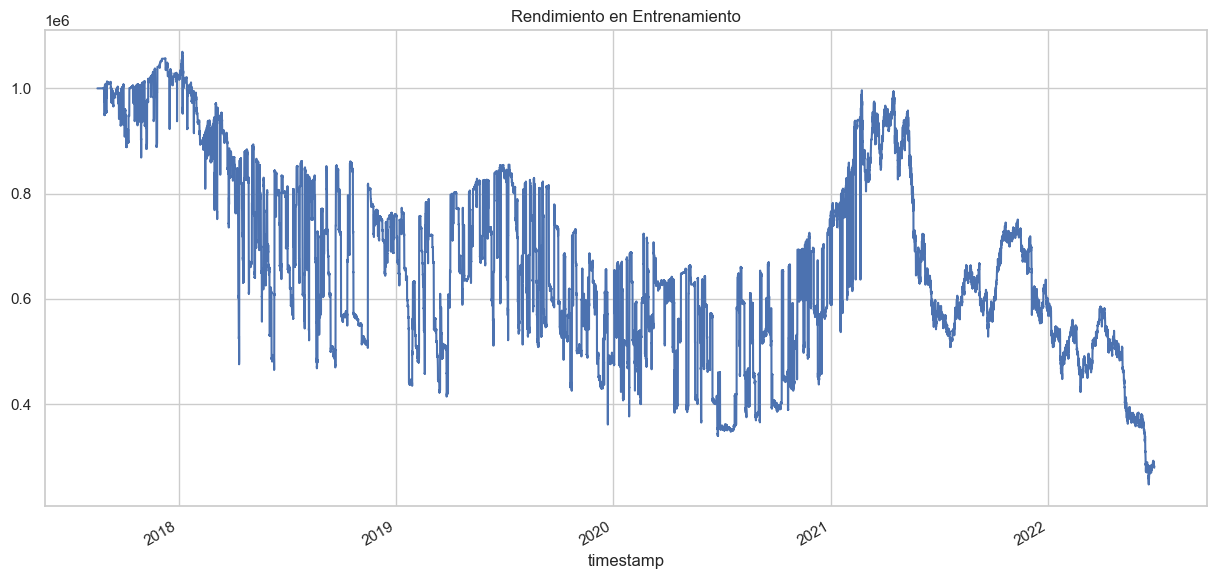

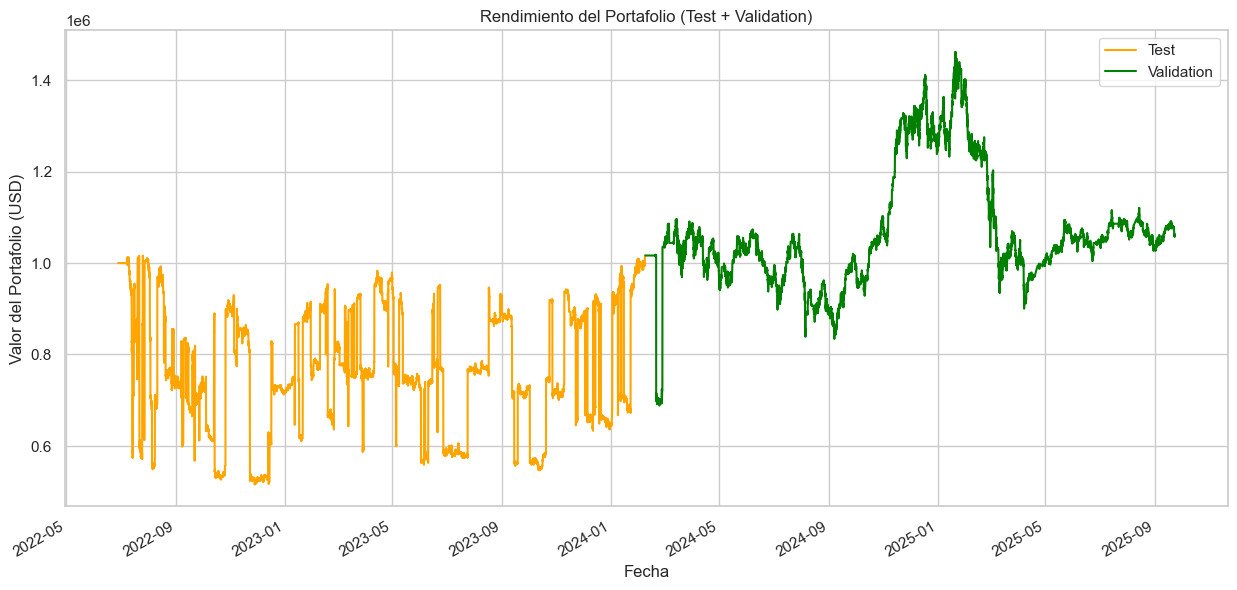

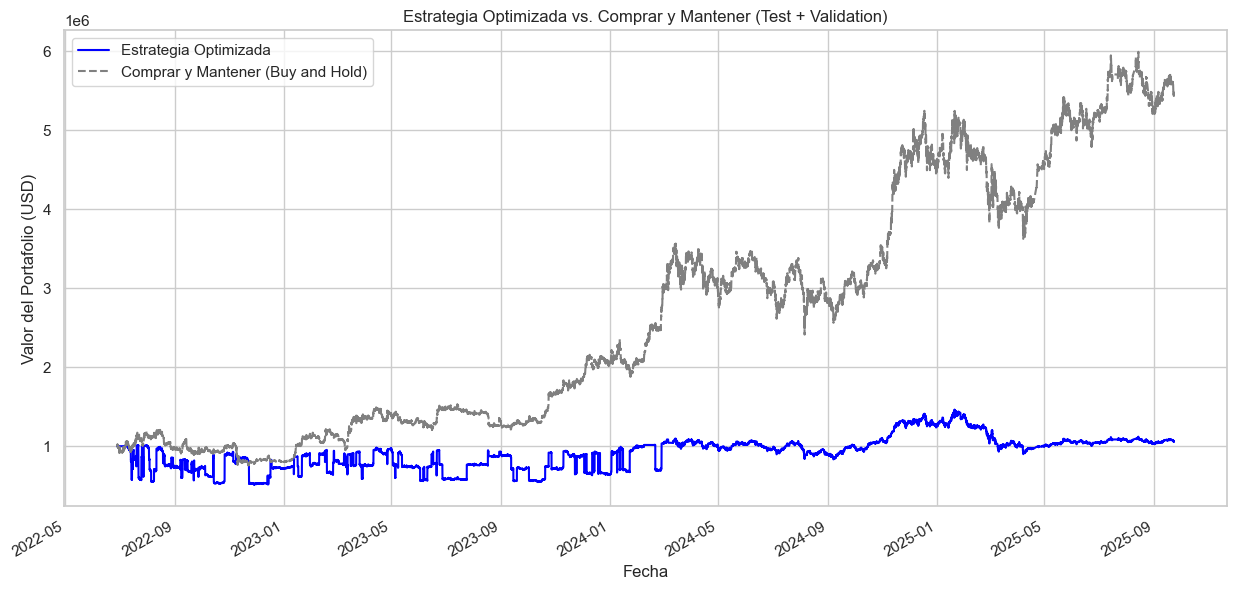

In [13]:
if __name__ == "__main__":
    main()